## 3. Implementierung der Hauptkomponentenanalyse

Wir beginnen zunächst mit einem schon bekannten Datensatz *Boston Housing*. Zur praktischen Berechnung der Hauptkomponentenanalyse gehen Sie folgt vor:

1. Gegeben eine Menge von $n$ $d$-dimensionalen Datenpunkten $\mathbf{x}_i$, berechnen Sie zuerst deren Mittelwert $\boldsymbol{\mu}_x = \frac{1}{n} \sum_{i=1}^n \mathbf{x}_i$ für jedes einzelne Merkmal und ziehen ihn von allen Datenpunkten ab (Zentrierung).
2. Normieren Sie dann alle Merkmale so, dass sie eine Varianz von 1 haben. Dieser Schritt ist optional, aber meist vorteilhaft.
3. Kopieren Sie alle $\mathbf{x}_i$ als Reihen in eine $n \times d$-Matrix $X$, die sog. Daten- oder Designmatrix.
4. Zur Lösung des Eigenwertproblens berechnen Sie die Singulärwertzerlegung von $X$ (z.B. mit `numpy.linalg.svd()`): $$ X = UDV^\top $$
Wer nicht weiß, was eine Singuärwertzerlegung ist oder macht, der lese bitte in den entsprechenden Wikipedia-Einträgen nach. Im Prinzip könnte man auch direkt die Eigenwerte der Kovarianzmatrix (s. Folie 12) berechnen (z.B. mit `numpy.linalg.eig()`), diese Methode ist aber meist aufwändiger und numerisch weniger stabil.
5. Die ersten $r$ Basisvektoren $\mathbf{q}_i$  (d.h die ersten $r$ Hauptkomponenten) sind die ersten $r$ Spalten der orthogonalen $d \times d$-Matrix $V$.
6. Die Projektionen $a_i$ der Daten $\mathbf{x}_i$ auf die ersten $r$ Basisvektoren $\mathbf{q}_i$ (d.h die neuen Variablenwerte im neuen Koordinatensystem) sind die die ersten $r$ Spalten der $n \times d$-Matrix $UD$.
7. Die Standardabweichungen entlang der Hauptkomponenten $\mathbf{q}_i$ sind die Diagonalelemente der Diagonalmatrix $D$ geteilt durch $\sqrt{n - 1}$.

Aufgaben:

a) Implementieren Sie ein Python-Modul, das eine Funktion zur Hauptkomponentenanalyse nach obigem Schema zur Verfügung stellt.

In [1]:
def pca(X, r=1, normalize=True):
    import numpy as np

    # 1. Zentrierung
    mu_x = np.mean(X, axis=0)
    X_centered = X - mu_x

    # 2. Normalisierung
    if normalize:
        std_x = np.std(X_centered, axis=0, ddof=1)
        X_normalized = X_centered / std_x
    else:
        X_normalized = X_centered

    # 3. Designmatrix ist X_normalized

    # 4. Singulärwertzerlegung
    U, S, Vt = np.linalg.svd(X_normalized, full_matrices=False)
    D = np.diag(S)

    # 5. Auswahl der ersten r Hauptkomponenten
    Q_r = Vt.T[:, :r]

    # 6. Projektionen auf die ersten r Hauptkomponenten
    A_r = U[:, :r] @ D[:r, :r]

    # 7. Standardabweichungen entlang der Hauptkomponenten
    std_dev_r = S[:r] / np.sqrt(X.shape[0] - 1)

    return Q_r, A_r, std_dev_r

b) Testen Sie Ihr Modul innerhalb eines IPython-Notebooks am Datensatz *Boston Housing*. Lassen Sie dabei die Variable `TGT` weg. Stellen Sie Ihre Ergebnisse in einer Tabelle mit den Eigenwerten der Kovarianzmatrix (Achtung: die Diagonalelemente von $D$ müssen dafür quadriert und durch n − 1 geteilt werden. Warum?), dem Anteil der zugehörigen Hauptkomponente an an der Gesamtvarianz (“erklärte Varianz”) und der kumulativen erklärten Varianz dar, d.h. welchen Varianzanteil die ersten $n$ Komponenten zusammen erklären. Wieviele Dimensionen können Sie weglassen, wenn Sie 10%, 5% und 1% Fehler bei der Dimensionsreduktion zulassen?

In [2]:
import numpy as np
import pandas as pd

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
cols = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B',
        'LSTAT', 'TGT']
# Translation of the column names:
# CRIM: per capita crime rate by town
# ZN: proportion of residential land zoned for lots over 25,000 sq.ft
# INDUS: proportion of non-retail business acres per town
# CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
# NOX: nitric oxides concentration (parts per 10 million)
# RM: average number of rooms per dwelling
# AGE: proportion of owner-occupied units built prior to 1940
# DIS: weighted distances to five Boston employment centres
# RAD: index of accessibility to radial highways
# TAX: full-value property-tax rate per $10,000
# PTRATIO: pupil-teacher ratio by town
# B: ?
# LSTAT: % lower status of the population
# TGT: Median value of owner-occupied homes in $1000's
boston = pd.read_csv(url, sep=' ', skipinitialspace=True, header=None, names=cols,
                     index_col=False)

# Entfernen der Zielvariable TGT
boston_data = boston.drop(columns=['TGT'])
X = boston_data.values
Q_r, A_r, std_dev_r = pca(X, r=X.shape[1], normalize=True)
eigenvalues = (std_dev_r ** 2) * (
        X.shape[0] - 1)  # Quadrieren und durch n-1 teilen weil: Varianz = (Standardabweichung)^2
explained_variance = eigenvalues / np.sum(eigenvalues)
cumulative_explained_variance = np.cumsum(explained_variance)
pca_results = pd.DataFrame({
    'Eigenvalue': eigenvalues,
    'Explained Variance': explained_variance,
    'Cumulative Explained Variance': cumulative_explained_variance
})
print(pca_results)


# Bestimmung der Anzahl der Dimensionen, die weggelassen werden können
def dimensions_to_retain(threshold):
    return np.argmax(cumulative_explained_variance >= (1 - threshold)) + 1


for error in [0.10, 0.05, 0.01]:
    dims = dimensions_to_retain(error)
    print(f"Dimensions to retain for {error * 100}% error: {dims}")

     Eigenvalue  Explained Variance  Cumulative Explained Variance
0   3094.058657            0.471296                       0.471296
1    723.803937            0.110252                       0.581548
2    627.521420            0.095586                       0.677134
3    433.075430            0.065967                       0.743101
4    421.582048            0.064217                       0.807318
5    331.990624            0.050570                       0.857888
6    270.354824            0.041181                       0.899069
7    200.029144            0.030469                       0.929538
8    139.856381            0.021303                       0.950841
9    111.220102            0.016941                       0.967783
10    93.937255            0.014309                       0.982091
11    85.498003            0.013023                       0.995115
12    32.072177            0.004885                       1.000000
Dimensions to retain for 10.0% error: 8
Dimensions to retain f

c) Berechnen Sie die Matrix der Korrelationskoeffizienten für die transformierten Variablen und interpretieren Sie das Ergebnis.

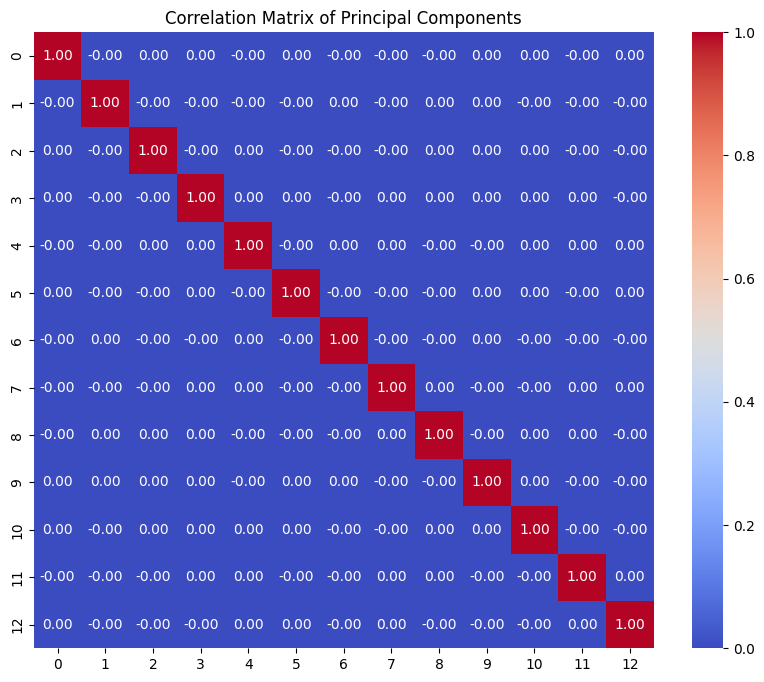

In [6]:
import numpy as np

correlation_matrix = np.corrcoef(A_r, rowvar=False)
correlation_df = pd.DataFrame(correlation_matrix)

# Anzeige der Korrelationsmatrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Principal Components')
plt.show()

# Interpretation: Die Korrelationsmatrix zeigt, dass die transformierten Variablen (Hauptkomponenten) unkorreliert sind, was ein zentrales Merkmal der PCA ist. Dies bedeutet, dass jede Hauptkomponente unabhängige Informationen über die Daten enthält.

d) Berechnen Sie den Korrelationskoeffizienten der Projektionen auf die ersten drei Hauptkomponenten mit den ursprünglichen Variablen. Interpretieren Sie Ihr Ergebnis.

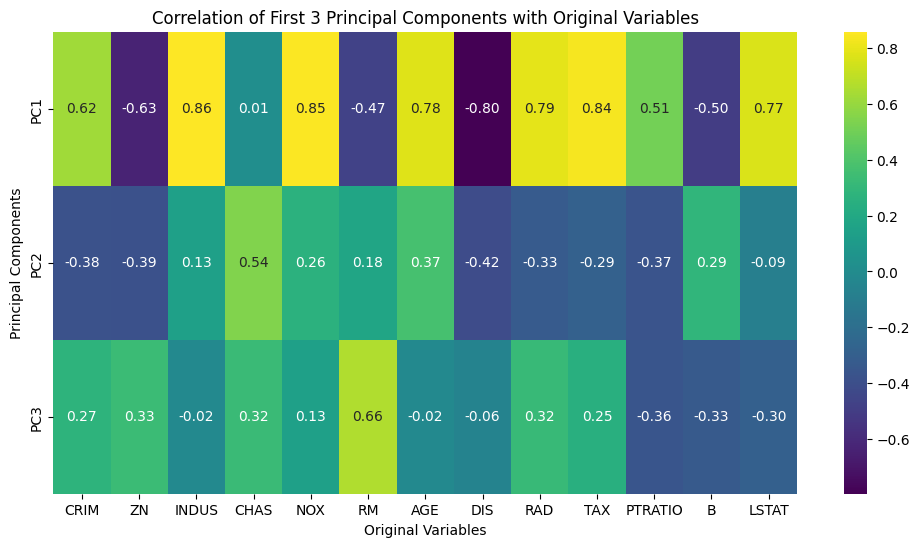

In [9]:
original_data = boston_data.values
projections_first_3 = A_r[:, :3]
correlation_with_original = np.corrcoef(projections_first_3.T, original_data.T)[:3, 3:]

# Replace the generic numeric labels by meaningful names: use original variable names as columns
correlation_with_original_df = pd.DataFrame(
    correlation_with_original,
    index=[f'PC{i + 1}' for i in range(correlation_with_original.shape[0])],
    columns=list(boston_data.columns)
)

# Anzeige der Korrelationsmatrix
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_with_original_df, annot=True, fmt=".2f", cmap='viridis', cbar=True)
plt.title('Correlation of First 3 Principal Components with Original Variables')
plt.xlabel('Original Variables')
plt.ylabel('Principal Components')
plt.show()

# Interpretation: Der Korrelationskoeffizient zwischen den Projektionen auf die ersten drei Hauptkomponenten und den ursprünglichen Variablen zeigt, wie stark jede Hauptkomponente mit den ursprünglichen Variablen korreliert ist. Hohe Korrelationswerte deuten darauf hin, dass bestimmte ursprüngliche Variablen stark zur Bildung der jeweiligen Hauptkomponente beitragen. Dies kann helfen, die Bedeutung der Hauptkomponenten zu verstehen und welche ursprünglichen Variablen am wichtigsten sind.

e. Stellen Sie die ersten beiden der neuen Variablen als Scatterplot dar (am besten in Pandas-Dataframe importieren). Plotten Sie dabei alle Datenpunkte mit einem Hauspreis oberhalb des Medians aller Hauspreise in einer anderen Farbe als die Datenpunkte unterhalb. Eignen sich die beiden neuen Variablen zur Vorhersage des Hauspreises?

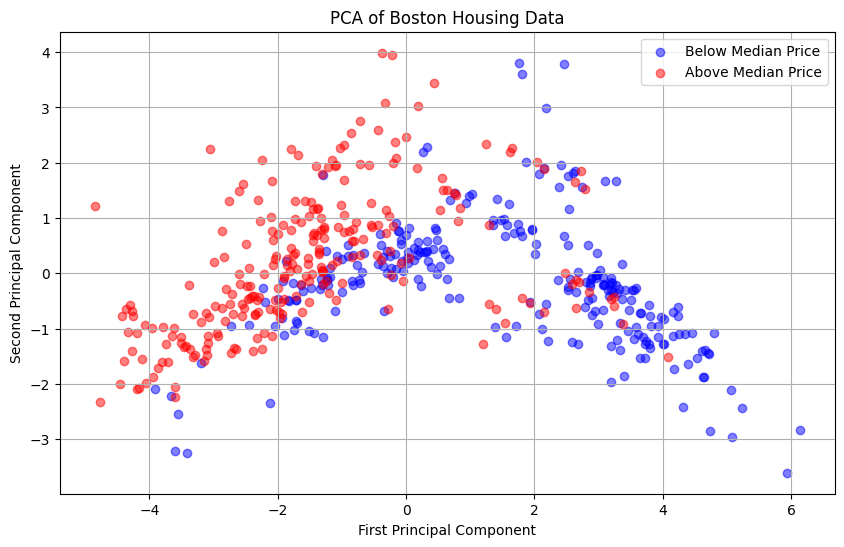

In [10]:
import matplotlib.pyplot as plt

median_price = boston['TGT'].median()
high_price_indices = boston['TGT'] > median_price
low_price_indices = boston['TGT'] <= median_price
plt.figure(figsize=(10, 6))
plt.scatter(A_r[low_price_indices, 0], A_r[low_price_indices, 1], color='blue', label='Below Median Price', alpha=0.5)
plt.scatter(A_r[high_price_indices, 0], A_r[high_price_indices, 1], color='red', label='Above Median Price', alpha=0.5)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Boston Housing Data')
plt.legend()
plt.grid()
plt.show()
# Interpretation: Es braucht noch mehr Hauptkomponenten, da viele Punkte überlappen. Die ersten beiden Hauptkomponenten allein scheinen nicht ausreichend zu sein, um den Hauspreis klar zu trennen.

In [4]:
%load_ext version_information
%version_information numpy, pandas, matplotlib

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.12.12 64bit [MSC v.1929 64 bit (AMD64)]
IPython 9.6.0
OS Windows 10 10.0.19045 SP0
numpy 2.3.3
pandas 2.3.3
matplotlib 3.10.7
Mon Oct 20 11:52:40 2025 Mitteleuropäische Sommerzeit